In [1]:
!pip install Konlpy > /dev/null

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 네이버 영화 리뷰 데이터로 검색
train_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', sep='\t')
test_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', sep='\t')

- 데이터 전처리

In [4]:
# Null 데이터가 있는지 확인
train_df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [5]:
# Null 데이터 제거
train_df.dropna(how='any', inplace=True) 
train_df.shape

(149995, 3)

In [6]:
# 중복여부 확인
train_df.document.nunique()

146182

In [7]:
# 중복 데이터 제거
train_df.drop_duplicates(subset=['document'], inplace=True) 
train_df.shape

(146182, 3)

In [8]:
# 긍정(1)/부정(0) 분포
train_df.label.value_counts()

0    73342
1    72840
Name: label, dtype: int64

In [9]:
test_df.isna().sum()

id          0
document    3
label       0
dtype: int64

In [10]:
test_df.dropna(how='any', inplace=True)

In [11]:
test_df.document.nunique()

49157

In [12]:
test_df.drop_duplicates(subset=['document'], inplace=True)
test_df.shape

(49157, 3)

In [13]:
test_df.label.value_counts()

1    24711
0    24446
Name: label, dtype: int64

### 2. 텍스트 전처리
- train dataset

In [14]:
# 한글 이외의 문자는 공백으로 처리하고 strip
train_df.document = train_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
train_df.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [15]:
# '' 만 남은 데이터 --> np.nan 으로 대체한 후 제거
train_df.document.replace('', np.nan, inplace=True)
train_df.document.isna().sum()

789

In [16]:
train_df.dropna(how='any', inplace=True)
train_df.shape

(145393, 3)

- test dataset

In [17]:
test_df.document = test_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
test_df.document.replace('', np.nan, inplace=True)
test_df.dropna(how='any', inplace=True)
test_df.shape

(48852, 3)

### 3. 한글 형태소 분석

In [18]:
from konlpy.tag import Okt
okt = Okt()

In [20]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']

In [21]:
from tqdm.notebook import tqdm

X_train = []
for sentence in tqdm(train_df.document):
    morphs = okt.morphs(sentence, stem=True)
    tmp_X = [word for word in morphs if word not in stopwords]
    X_train.append(tmp_X)

  0%|          | 0/145393 [00:00<?, ?it/s]

In [22]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

### 4. Keras Tokenizer --> Train/Test dataset
- 수업중 시간 관계상 train dataset을 train/test dataset으로 분할해서 사용

In [23]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

In [25]:
len(t.word_index)

43118

In [26]:
# 빈도수 상위 20,000개 단어로 인코딩
num_words = 20000
t = Tokenizer(num_words=num_words)
t.fit_on_texts(X_train)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_train, train_df.label.values, stratify=train_df.label.values,
    test_size=0.2, random_state=seed
)

In [29]:
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)

AttributeError: ignored

In [30]:
# 데이터의 최대/평균 길이
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(70, 10.594717746788865)

In [33]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_train.shape, X_test.shape

((116314, 40), (29079, 40))

### 5. LSTM 모델 정의/설정/학습

In [34]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [35]:
model = Sequential([
                    Embedding(num_words, 120, input_length=max_len),
                    LSTM(128),
                    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 120)           2400000   
                                                                 
 lstm (LSTM)                 (None, 128)               127488    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,527,617
Trainable params: 2,527,617
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])
model_path = 'best-naver-movie-lstm.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=5)

In [37]:
hist = model.fit(
    X_train, y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc,es]
)

Epoch 1/30
722/727 [============================>.] - ETA: 0s - loss: 0.4036 - accuracy: 0.8143
Epoch 1: val_loss improved from inf to 0.36443, saving model to best-naver-movie-lstm.h5
727/727 [==============================] - 19s 11ms/step - loss: 0.4033 - accuracy: 0.8145 - val_loss: 0.3644 - val_accuracy: 0.8390
Epoch 2/30
726/727 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.8680
Epoch 2: val_loss improved from 0.36443 to 0.36016, saving model to best-naver-movie-lstm.h5
727/727 [==============================] - 7s 10ms/step - loss: 0.3106 - accuracy: 0.8680 - val_loss: 0.3602 - val_accuracy: 0.8420
Epoch 3/30
721/727 [============================>.] - ETA: 0s - loss: 0.2587 - accuracy: 0.8923
Epoch 3: val_loss did not improve from 0.36016
727/727 [==============================] - 7s 10ms/step - loss: 0.2590 - accuracy: 0.8921 - val_loss: 0.3709 - val_accuracy: 0.8445
Epoch 4/30
726/727 [============================>.] - ETA: 0s - loss: 0.2136 - accurac

In [38]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

909/909 [==============================] - 4s 4ms/step - loss: 0.3569 - accuracy: 0.8432


[0.35686296224594116, 0.8431513905525208]

6. 실제 데이터 예측

In [57]:
review = '이 영화 개꿀잼 ㅋㅋㅋ'

In [58]:
import re
review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ', review).strip()

In [61]:
morphs = okt.morphs(review, stem=True)
morphs = [word for word in morphs if word not in stopwords]
encoded = t.texts_to_sequences([morphs])
padded = pad_sequences(encoded, maxlen=max_len)
score = float(best_model.predict(padded))           # best_model.predict(padded)[0][0]
print('긍정' if score > 0.5 else '부정')

긍정


In [62]:
def sentiment_predict(review,tokenizer=t, max_len=max_len):
  review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ', review).strip()
  morphs = okt.morphs(review, stem=True)
  morphs = [word for word in morphs if word not in stopwords]
  encoded = t.texts_to_sequences([morphs])
  padded = pad_sequences(encoded, maxlen=max_len)
  score = float(best_model.predict(padded))           # best_model.predict(padded)[0][0]
  return f'긍정({score*100:.2f}%)' if score > 0.5 else f'부정({(1-score)*100:.2f}%)'

In [63]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

'긍정(93.83%)'

In [73]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

'부정(99.55%)'

7. 학습과정 시각화

In [74]:
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
y_vacc = hist.history['val_accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

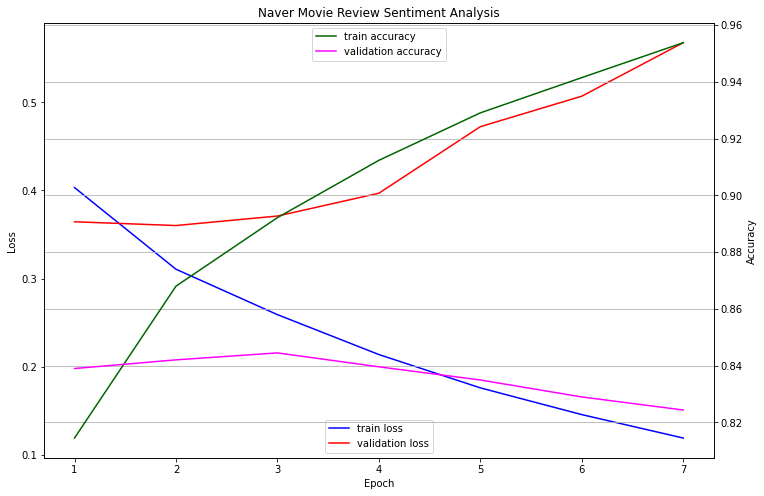

In [85]:
# X축은 공유
# y축의 좌측: loss, y축의 우측: accuracy
import matplotlib.pyplot as plt
fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.plot(xs, y_loss, c='blue', label='train loss')
ax0.plot(xs, y_vloss, c='red', label='validation loss')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')
ax1.plot(xs, y_acc, c='darkgreen', label='train accuracy')
ax1.plot(xs, y_vacc, c='magenta', label='validation accuracy')
ax1.set_ylabel('Accuracy')
ax0.legend(loc = 'lower center'); ax1.legend(loc = 'upper center')
plt.title('Naver Movie Review Sentiment Analysis')
plt.grid(); plt.show()